# library

In [1]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random

2022-06-11 15:53:58.862289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## mk_cd 함수

In [2]:
## 함수
def mk_cd(x):
    if type(x) == str:
        if x.isalpha():
            return x
        else:
            if len(x) == 6:
                return x
            else:
                return "0"*(6-len(x))+x
    elif type(x) == int:
        x = str(x)
        return "0"*(6-len(x))+x

# 슬라이싱 준비

In [3]:
len_a2012 = 284412
len_a2013 = 242826
len_a2014 = 242448
len_a2015 = 314361
len_a2016 = 263593
len_a2017 = 216591
len_a2018 = 307395
len_a2019 = 278610
len_a2020 = 371006
len_a2021 = 321808

In [4]:
len1215 = len_a2012+len_a2013+len_a2014+len_a2015 # y:2015
len1316 = len1215+len_a2016 # y:2016
len1417 = len1316+len_a2017 # y:2017
len1518 = len1417+len_a2018 # y:2018
len1619 = len1518+len_a2019 # y:2019
len1720 = len1619+len_a2020 # y:2020
len1821 = len1720+len_a2021 # y:2021

## [0], [1]은 train 슬라이싱 인덱스, [2]는 test인덱스로 구성

In [5]:
slicing_dic = {'1215':[0, len1215, len_a2015],
               '1316':[len_a2012, len1316, len_a2016],
               '1417':[len_a2012+len_a2013, len1417, len_a2017],
               '1518':[len_a2012+len_a2013+len_a2014, len1518, len_a2018],
               '1619':[len_a2012+len_a2013+len_a2014+len_a2015, len1619, len_a2019],
               '1720':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016,len1720, len_a2020],
               '1821':[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016+len_a2017,len1821, len_a2021]}

## 슬라이싱 테스트

In [6]:
# d1221[:len1215]
# d1221[len_a2012:len1316]
# d1221[len_a2012+len_a2013:len1417]
# d1221[len_a2012+len_a2013+len_a2014:len1518]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015:len1619]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016:len1720]
# d1221[len_a2012+len_a2013+len_a2014+len_a2015+len_a2016+len_a2017:len1821]

# data load 3 여기부터 하면 됨.

In [6]:
d1221 = pd.read_feather('d1221.ftr', columns = None, use_threads = True)

In [7]:
d1221.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843050 entries, 0 to 2843049
Columns: 823 entries, date to NextChange
dtypes: category(1), float64(821), int64(1)
memory usage: 17.4 GB


# category to object

In [8]:
d1221['code'] = list(map(mk_cd, d1221['code'])) # mk_cd함수 적용시켜야 ftr만들 때 에러 안남.

In [9]:
d1221.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843050 entries, 0 to 2843049
Columns: 823 entries, date to NextChange
dtypes: float64(821), int64(1), object(1)
memory usage: 17.4+ GB


# modeling

In [10]:
results = []
def my_regressor():
    X = d1221.iloc[:,2:-1] # 1221 데이터
    y = d1221.iloc[:,-1]
    from sklearn.linear_model import LinearRegression # 일반 회귀 모델
    from sklearn.linear_model import Ridge, Lasso, ElasticNet # Norm 규제 회귀 모델
    from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor # decision tree 앙상블 모델, 배깅
    from xgboost import XGBRegressor # decision tree 앙상블 모델, 부스팅
    import lightgbm as lgb
    from sklearn.model_selection import GridSearchCV
#     from sklearn.model_selection import cross_val_score # model 검증
    
#     from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import cross_val_score
    
    from sklearn.dummy import DummyRegressor
    from sklearn.metrics import mean_squared_error as mse # 모델 평가 지표 scoring (mse)
    from sklearn.metrics import r2_score as r2
    
    import ast # convert string to function
    
    # seed 고정
    user_seed = 0
    random.seed(user_seed) # seed 고정
    
    # (같은 줄에 써놓은 애들끼리 하이퍼파리미터 구성 비슷하거나 같음)
    linear = LinearRegression(n_jobs=64)
    ridge, lasso, elasticnet = Ridge(), Lasso(alpha=0.01, max_iter=10, random_state=user_seed), ElasticNet(alpha=0.01, max_iter=10, random_state=user_seed)
    # [lasso 학습시간 단축 하이퍼파라미터 참고](https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-3-%EC%84%A0%ED%98%95-%EB%AA%A8%EB%8D%B8/comment-page-1/)
    # [elastic net 참고](https://soobarkbar.tistory.com/30)
    # elastic net은 큰 데이터 셋에서 잘 작동함. + ridge&lasso의 장점 모두 가짐.
    # [모델훈련](https://taek98.tistory.com/15)
    ardr_linear, bayesian_ridge = ARDRegression(verbose = True), BayesianRidge(verbose = True) # n_iter=10, 
    DecisionTree = DecisionTreeRegressor(max_depth = 10, random_state=user_seed, max_leaf_nodes=4)
    random_forest = RandomForestRegressor(n_estimators=10,
                                          n_jobs=64,
                                          max_depth=10,
                                          random_state=user_seed,
                                          verbose=2,
                                          max_leaf_nodes=4)
    xgboost_linear = XGBRegressor(n_jobs=64, max_depth=10, n_estimators=10, learning_rate=0.05) # 16에서 64로 증가 # , verbosity=2
    gbm = lgb.LGBMRegressor(num_leaves=31,
                            learning_rate=0.05,
                            n_estimators=20)

    dummy = DummyRegressor(strategy = 'mean')
    
    my_model_list = ['DecisionTree', 'random_forest',
                     'xgboost_linear', 'gbm', 'dummy',
                     
                     'linear', 'ridge', 'lasso', 'elasticnet',
                     'ardr_linear', 'bayesian_ridge'] # 오래 걸리는걸 앞으로 뺌
    
    i = 0
    
    ######################################################################### fitting
    for model_nm in tqdm(my_model_list):
        cntcnt = 0
        # cv
        for slicer in slicing_dic:
            tmpX = X[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True)
            tmpy = y[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True)
#             tmp_all = d1221[slicing_dic[slicer][0]:slicing_dic[slicer][1]].reset_index(drop = True) # 전체데이터

            X_train = tmpX[:-slicing_dic[slicer][2]]
            X_test = tmpX[-slicing_dic[slicer][2]:]
            y_train = tmpy[:-slicing_dic[slicer][2]]
            y_test = tmpy[-slicing_dic[slicer][2]:]
            
            # train끼리 idx 같아야 하므로
            len_train = slicing_dic[slicer][1]-(slicing_dic[slicer][2]+slicing_dic[slicer][0]) # 혹은 tmp_train.shape[0]
            len(list(range(len_train)))
            train_idx = list(range(len_train))
            random.shuffle(train_idx) # 자동으로 덮어쓰기

            len_train_to_test = slicing_dic[slicer][1]-slicing_dic[slicer][0]
            test_idx = list(range(len_train,len_train_to_test)) # +1 안해줘도 되는 거 위 cell에서 확인
            len(test_idx)
            random.shuffle(test_idx) # 자동으로 덮어쓰기
            
            X_train = X_train.loc[train_idx]
            y_train = y_train.loc[train_idx]
            X_test = X_test.loc[test_idx]
            y_test = y_test.loc[test_idx]
            ###########################################
            y_train = np.array(y_train).reshape(-1,1) # 1열짜리로 만드는 것
            y_test = np.array(y_test).reshape(-1,1)

            ######################################################## cv를 위한 데이터 slicing 작업 끝

            # fitting은 cv 안에 넣기
            if model_nm == 'gbm':
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='l1',
                                            early_stopping_rounds=5)
                y_pred_test = model_.predict(X_test, num_iteration=gbm.best_iteration_) # 예측

            elif model_nm == 'xgboost_linear': # xgboost_linear가 느려서
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train,
                                            eval_set=[(X_test, y_test)],
                                            eval_metric='rmse',
                                            early_stopping_rounds=5) # ,verbose = True
                y_pred_test = model_.predict(X_test) # 예측
                
            else:
                cntcnt += 1
                print(f'$$$$$---{cntcnt}')
                model_ = eval(model_nm).fit(X_train, y_train)
                y_pred_test = model_.predict(X_test) # 예측

            mse_score = mse(y_test, y_pred_test)
            r2_score = r2(y_test, y_pred_test)
            cv_scores = cross_val_score(eval(model_nm), tmpX, tmpy, cv=7)

            results.append([i, f'{model_nm}', mse_score, r2_score, cv_scores]) #[:str(model).index("(")]
            i+=1
        ################################################################
        print(results[-7:])
    return results#score_dic#[0]

[검색어: xgbregressor___] <br>

[xgb regressor parameter](https://xgboost.readthedocs.io/en/stable/parameter.html) <br>
[xgbregressor라고 검색해서 classxgboost.dask.DaskXGBRegressor라고 돼있는 파란 박스 보기](https://xgboost.readthedocs.io/en/stable/python/python_api.html) - 여기서 fit 안에 parameter도 확인 <br>
[xgboost](https://injo.tistory.com/44) <br>
[xgboost metric 확인](https://deep-deep-deep.tistory.com/160) <br>
<br>

[Decision Tree regression 병렬처리] <br>
[병렬처리를통한 속도 해결 논문](https://patents.google.com/patent/KR20160001375A/ko) <br>
[결정 트리의 앙상블](https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-6-%EA%B2%B0%EC%A0%95-%ED%8A%B8%EB%A6%AC%EC%9D%98-%EC%95%99%EC%83%81%EB%B8%94/)

In [11]:
import time
start = time.time()
_ = my_regressor()
results
time.time()-start

# DT에 max_leaf_node 추가 (4시간 15분+ 걸림)
# RF 3시간 30분+ 걸림
# XGB 30분 걸려야 함. (확인)
# gbm 10분 걸려야 함. (확)
# dummy 1분 걸려야 함. (확) 00:23분
# linear 13분 걸려야 함. (확)
# ridge 6분 걸려야 함. (확)
# lasso 6분 걸려야 함. (확)
# elasicnet 6분 걸려야 함. (확)
# ardr_linear 6분 걸려야 함. (7분 걸림)
# bayesian_ridge 24분 걸려야 함.

  0%|                                                    | 0/11 [00:00<?, ?it/s]

$$$$$---1
$$$$$---2
$$$$$---3
$$$$$---4
$$$$$---5
$$$$$---6
$$$$$---7


  9%|███▎                                | 1/11 [4:14:52<42:28:47, 15292.72s/it]

[[0, 'DecisionTree', 20.447291795548274, 0.0035265375603458216, array([0.01405012, 0.01226554, 0.01315876, 0.01519267, 0.01197257,
       0.00270937, 0.00612972])], [1, 'DecisionTree', 14.87985054605241, -0.002389782688752895, array([ 0.00946988,  0.01217002,  0.01289997,  0.00196199,  0.00231116,
       -0.00037709, -0.00230182])], [2, 'DecisionTree', 13.639345690521145, 0.0011683704216332025, array([ 0.00499926, -0.01249419,  0.00188581,  0.00322636,  0.00106242,
       -0.00099545,  0.00223977])], [3, 'DecisionTree', 16.525384090038386, -0.0011049997821852564, array([-0.0182933 , -0.0007949 , -0.00016497,  0.00152865,  0.0029646 ,
        0.00178123,  0.00144303])], [4, 'DecisionTree', 14.794120517280113, 0.005122367540025818, array([0.0012748 , 0.00402795, 0.00087567, 0.00449716, 0.00465782,
       0.00558872, 0.00466857])], [5, 'DecisionTree', 23.263032413330418, 0.0002753500199895731, array([-0.00449635, -0.00344979, -0.00329516, -0.00480872,  0.00962501,
        0.02132431,  0.0

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10building tree 5 of 10

building tree 6 of 10building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10



[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.5min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.2min remaining:  5.1min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.0min remaining:  

building tree 7 of 10
building tree 5 of 10
building tree 3 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.1min remaining:  5.0min


building tree 4 of 10
building tree 9 of 10
building tree 10 of 10
building tree 2 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.1min remaining:  4.8min


building tree 6 of 10
building tree 5 of 10
building tree 1 of 10
building tree 7 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 2 of 10
building tree 7 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished


building tree 5 of 10
building tree 9 of 10
building tree 3 of 10
building tree 8 of 10


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.2min


building tree 8 of 10
building tree 4 of 10
building tree 6 of 10
building tree 8 of 10
building tree 1 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.


building tree 10 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.0min remaining:  7.0min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished


building tree 8 of 10
building tree 1 of 10
building tree 1 of 10


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 3 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 5 of 10
building tree 5 of 10
building tree 7 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.1min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---2


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 8 of 10
building tree 10 of 10
building tree 2 of 10
building tree 5 of 10
building tree 9 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.6min remaining:  3.8min


building tree 10 of 10
building tree 9 of 10
building tree 6 of 10
building tree 2 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.8min remaining:  9.0min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.8min remaining:  8.8min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.8min finished
[Pa

building tree 6 of 10
building tree 6 of 10
building tree 2 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.7min remaining:  8.7min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.9min remaining:  6.7min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  1.9min remaining:  

building tree 3 of 10
building tree 7 of 10
building tree 2 of 10
building tree 9 of 10
building tree 3 of 10
building tree 5 of 10
building tree 8 of 10
building tree 4 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.0min remaining:  4.7min


building tree 6 of 10
building tree 6 of 10
building tree 1 of 10
building tree 1 of 10
building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---3


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 10 of 10
building tree 10 of 10
building tree 7 of 10
building tree 6 of 10
building tree 3 of 10
building tree 3 of 10
building tree 8 of 10
building tree 5 of 10
building tree 9 of 10
building tree 7 of 10
building tree 8 of 10
building tree 4 of 10
building tree 5 of 10
building tree 9 of 10
building tree 2 of 10
building tree 9 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.7min remaining:  6.2min


building tree 3 of 10
building tree 1 of 10
building tree 1 of 10
building tree 1 of 10
building tree 2 of 10
building tree 9 of 10
building tree 1 of 10
building tree 9 of 10
building tree 4 of 10
building tree 7 of 10
building tree 6 of 10
building tree 3 of 10
building tree 6 of 10
building tree 2 of 10
building tree 10 of 10
building tree 2 of 10
building tree 7 of 10
building tree 3 of 10
building tree 8 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.9min remaining:  6.7min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.8min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.6min remaining:  8.5min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.7min finished
[Pa

$$$$$---4


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 7 of 10
building tree 7 of 10
building tree 5 of 10
building tree 6 of 10
building tree 5 of 10
building tree 7 of 10
building tree 1 of 10
building tree 3 of 10
building tree 10 of 10
building tree 2 of 10
building tree 4 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 2 of 10
building tree 3 of 10
building tree 2 of 10
building tree 9 of 10
building tree 10 of 10
building tree 10 of 10
building tree 6 of 10
building tree 9 of 10
building tree 9 of 10
building tree 3 of 10
building tree 4 of 10
building tree 1 of 10
building tree 8 of 10
building tree 8 of 10
building tree 8 of 10
building tree 1 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.6min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  4.0min remaining:  9.3min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.9min remaining:  

building tree 4 of 10
building tree 6 of 10
building tree 2 of 10
building tree 10 of 10
building tree 10 of 10
building tree 1 of 10
building tree 8 of 10
building tree 7 of 10
building tree 2 of 10
building tree 10 of 10
building tree 3 of 10
building tree 9 of 10
building tree 6 of 10
building tree 2 of 10
building tree 4 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.9min remaining:  6.8min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 10 of 10
building tree 9 of 10
building tree 9 of 10
building tree 4 of 10
building tree 8 of 10
building tree 9 of 10
building tree 4 of 10
building tree 6 of 10


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.0min remaining:  7.1min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.


building tree 4 of 10
building tree 5 of 10
building tree 10 of 10
building tree 5 of 10
building tree 8 of 10
building tree 4 of 10
building tree 9 of 10
building tree 10 of 10
building tree 4 of 10
building tree 6 of 10
building tree 4 of 10
building tree 6 of 10
building tree 10 of 10
building tree 3 of 10
building tree 5 of 10
building tree 9 of 10
building tree 1 of 10
building tree 1 of 10
building tree 6 of 10
building tree 5 of 10
building tree 1 of 10
building tree 5 of 10
building tree 3 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.0min remaining:  6.9min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.0min remaining:  7.0min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 8 of 10
building tree 6 of 10
$$$$$---5


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 10 of 10
building tree 2 of 10
building tree 10 of 10
building tree 8 of 10
building tree 7 of 10
building tree 3 of 10
building tree 3 of 10
building tree 5 of 10
building tree 9 of 10
building tree 1 of 10
building tree 1 of 10
building tree 7 of 10
building tree 8 of 10
building tree 10 of 10
building tree 7 of 10
building tree 5 of 10
building tree 1 of 10
building tree 7 of 10
building tree 6 of 10
building tree 3 of 10
building tree 8 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 4 of 10
building tree 10 of 10
building tree 2 of 10
building tree 5 of 10
building tree 6 of 10
building tree 5 of 10
building tree 2 of 10
building tree 7 of 10
building tree 4 of 10
building tree 1 of 10
building tree 3 of 10
build

[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.5min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.9min remaining:  6.8min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.2min remaining:  

$$$$$---6


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 6 of 10
building tree 3 of 10
building tree 4 of 10
building tree 10 of 10
building tree 9 of 10
building tree 8 of 10
building tree 7 of 10
building tree 7 of 10
building tree 6 of 10
building tree 3 of 10
building tree 2 of 10
building tree 9 of 10
building tree 2 of 10
building tree 6 of 10
building tree 2 of 10
building tree 4 of 10
building tree 10 of 10
building tree 7 of 10
building tree 1 of 10
building tree 4 of 10
building tree 3 of 10
building tree 8 of 10
building tree 5 of 10
building tree 5 of 10
building tree 5 of 10
building tree 1 of 10
building tree 10 of 10
building tree 9 of 10
building tree 8 of 10
building tree 1 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.7min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.2min remaining:  7.6min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.1min remaining:  

building tree 8 of 10
building tree 2 of 10
building tree 6 of 10
building tree 5 of 10
building tree 1 of 10
building tree 7 of 10
building tree 10 of 10
building tree 8 of 10
building tree 1 of 10
building tree 9 of 10
building tree 10 of 10
building tree 9 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


$$$$$---7


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 3 of 10
building tree 5 of 10
building tree 10 of 10
building tree 6 of 10
building tree 9 of 10
building tree 5 of 10
building tree 1 of 10
building tree 3 of 10
building tree 8 of 10
building tree 4 of 10
building tree 4 of 10
building tree 3 of 10
building tree 7 of 10
building tree 6 of 10
building tree 2 of 10
building tree 2 of 10
building tree 7 of 10
building tree 4 of 10


[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.0min remaining:  7.0min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.5min remaining:  8.3min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.4min remaining:  

building tree 3 of 10
building tree 3 of 10
building tree 7 of 10
building tree 6 of 10
building tree 6 of 10
building tree 10 of 10


[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  4.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.4min remaining:  8.0min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   3 out of  10 | elapsed:  3.5min remaining:  8.2min
[Parallel(n_jobs=64)]: Done  10 out of  10 | elapsed:  3.5min finished
[Pa

[[7, 'random_forest', 20.44565358450195, 0.003606373748426983, array([ 0.00246136,  0.00437214, -0.00323899,  0.01426546,  0.01267653,
        0.00297055,  0.00645231])], [8, 'random_forest', 14.845105995140418, -4.919581723150657e-05, array([0.00628882, 0.00923687, 0.01226374, 0.00106842, 0.00491803,
       0.00086677, 0.00144416])], [9, 'random_forest', 13.635969174568876, 0.001415638216396009, array([ 0.00544177, -0.00450218,  0.00189107,  0.00287889,  0.0008559 ,
       -0.00013156,  0.00241456])], [10, 'random_forest', 16.49362166407226, 0.0008191626618857528, array([-0.00563761,  0.00311593,  0.00045241,  0.00306874,  0.00390843,
        0.00097895,  0.00235553])], [11, 'random_forest', 14.823525748098751, 0.003144919378466504, array([0.00147878, 0.0040849 , 0.00258724, 0.00467767, 0.00515655,
       0.00575855, 0.00367187])], [12, 'random_forest', 23.258904670913353, 0.00045273901080500334, array([-0.00421108, -0.00324414, -0.00268638, -0.00379628,  0.0114286 ,
        0.031977 

 27%|██████████                           | 3/11 [8:15:58<18:26:27, 8298.47s/it]

[[14, 'xgboost_linear', 20.445327867524377, 0.003622247162259118, array([ 0.00270119, -0.01920002,  0.00051682,  0.01003605, -0.001402  ,
        0.00681282, -0.00236984])], [15, 'xgboost_linear', 14.894559049242977, -0.0033806295572236245, array([-3.28202133e-05,  5.87775331e-03,  8.63062709e-03,  5.26461520e-03,
        3.63829124e-03, -8.49103957e-04, -1.04103612e-03])], [16, 'xgboost_linear', 13.826892162422073, -0.012565964963726417, array([ 0.00731241,  0.001422  ,  0.00426586,  0.00379795, -0.00232177,
       -0.01147504, -0.00355902])], [17, 'xgboost_linear', 16.579007062304484, -0.004353470458950293, array([ 0.00116737, -0.00650393, -0.00175864, -0.00839824, -0.00364066,
        0.00363475,  0.00383983])], [18, 'xgboost_linear', 14.882148870249223, -0.0007973787057184989, array([ 4.95597575e-05,  1.59742721e-03, -2.29430973e-03,  9.87612812e-03,
        9.01707002e-03,  4.38568683e-03,  2.36826465e-03])], [19, 'xgboost_linear', 23.24790867122966, 0.0009252901270845326, array([

 36%|█████████████▍                       | 4/11 [8:25:57<10:13:31, 5258.78s/it]

[[21, 'gbm', 20.377643205573385, 0.006920775403688517, array([0.01750447, 0.01610233, 0.01174407, 0.01943906, 0.01377155,
       0.00827517, 0.00767508])], [22, 'gbm', 14.796051220430611, 0.0032554075999213783, array([0.00602095, 0.01526369, 0.01495503, 0.00869939, 0.01065227,
       0.0058684 , 0.00563005])], [23, 'gbm', 13.58815543170958, 0.004917116936858479, array([0.01414884, 0.00929487, 0.01125351, 0.01031913, 0.00491586,
       0.00616736, 0.00611833])], [24, 'gbm', 16.435068917226683, 0.004366278256822564, array([0.00708529, 0.00906092, 0.00280058, 0.00544855, 0.0038169 ,
       0.0139097 , 0.01578372])], [25, 'gbm', 14.808476405923647, 0.004156960202100102, array([0.0018516 , 0.00570835, 0.00456742, 0.01901596, 0.0192079 ,
       0.01137434, 0.00806986])], [26, 'gbm', 23.10335745366295, 0.007137352803111785, array([0.00185658, 0.01153771, 0.00991819, 0.00425886, 0.02870052,
       0.08113481, 0.08733085])], [27, 'gbm', 16.163302259078527, 0.0022705621727793224, array([0.010357

 45%|█████████████████▎                    | 5/11 [8:27:28<5:39:31, 3395.22s/it]

[[28, 'dummy', 20.537427949296163, -0.0008661363504212094, array([-1.70009117e-04, -2.34884934e-04, -2.46682078e-04, -9.65110624e-05,
       -6.78959358e-06, -5.08244771e-04, -7.06766075e-04])], [29, 'dummy', 14.844799344342732, -2.853810796898948e-05, array([-4.23316098e-04, -2.68705463e-04, -6.88936727e-05, -2.56941536e-04,
       -4.58500448e-04, -1.55067377e-05, -1.97571903e-05])], [30, 'dummy', 13.663214094243353, -0.000579551885362628, array([-8.07156907e-05, -2.86772300e-05, -4.08641203e-04, -2.62154475e-04,
       -2.29039216e-05, -1.14380780e-04, -5.96097037e-04])], [31, 'dummy', 16.518489350381895, -0.0006873176088264543, array([-6.17868121e-04, -8.18904985e-04, -1.89771782e-06, -3.93777863e-06,
       -2.86095030e-04, -3.43183450e-04, -6.40506254e-04])], [32, 'dummy', 14.870582145802054, -1.953757485351204e-05, array([-1.66068984e-04, -1.10042060e-04, -2.56316696e-05, -6.46524839e-05,
       -1.88067208e-04, -3.44907231e-07, -2.30689628e-05])], [33, 'dummy', 23.3024222404155

 55%|████████████████████▋                 | 6/11 [8:40:57<3:29:39, 2515.93s/it]

[[35, 'linear', 20.54202370140966, -0.0010901046424984795, array([-1.52580320e-03, -1.59972052e+05,  1.79551952e-03,  3.78879766e-03,
        3.40729510e-03, -7.08667900e-04,  3.61790592e-03])], [36, 'linear', 14.878200753010933, -0.0022786434213790674, array([-5.90552782e-02, -1.07878143e+01,  1.53074598e-03, -8.59846440e-03,
        4.86009758e-03,  2.85421155e-03, -1.34814466e-02])], [37, 'linear', 13.7170024447564, -0.004518560912211811, array([ 0.00818563, -0.00383357,  0.00561133,  0.0059827 ,  0.00020013,
        0.00176022, -0.00278919])], [38, 'linear', 16.8062533650501, -0.01812001341015379, array([ 0.00334053,  0.00234252, -0.00289987,  0.00143955, -0.00404967,
       -0.01948539,  0.00154861])], [39, 'linear', 14.936050899280056, -0.0044221918850047, array([-0.00073986,  0.00415489, -0.00339393,  0.01213842,  0.00899272,
        0.00928571,  0.00142224])], [40, 'linear', 23.765181626424372, -0.021304422443828575, array([-0.01948649, -0.04238908, -0.01990264, -0.01521807,  0

 64%|████████████████████████▏             | 7/11 [8:46:43<2:00:26, 1806.52s/it]

[[42, 'ridge', 20.49326438832787, 0.0012861201416252133, array([ 3.63893942e-03, -1.01845248e+04,  6.15737613e-03,  1.09373492e-02,
        8.29444866e-03,  4.77399226e-03,  6.43706286e-03])], [43, 'ridge', 14.924352683034593, -0.005387695018631344, array([-4.45543497e-02, -3.72614621e+00,  1.30394095e-02,  1.75529260e-03,
        7.87957721e-03,  4.11878423e-03,  1.14938266e-04])], [44, 'ridge', 13.687621649028053, -0.00236695710792878, array([ 0.01075166,  0.0056566 ,  0.00882092,  0.00822959,  0.00032359,
        0.00437414, -0.00134697])], [45, 'ridge', 16.852446943563734, -0.02091841265799399, array([ 0.00608359,  0.00458079, -0.00253694,  0.0025402 , -0.00387427,
       -0.02235075,  0.0022251 ])], [46, 'ridge', 14.926984204812955, -0.0038124732122972738, array([ 2.28361644e-05,  4.25151576e-03, -2.80673562e-03,  1.24744299e-02,
        1.16964391e-02,  9.67035512e-03,  2.10778685e-03])], [47, 'ridge', 23.744937227371548, -0.02043442302167464, array([-0.01664559, -0.03059095, -0.

 73%|███████████████████████████▋          | 8/11 [8:52:46<1:07:20, 1346.98s/it]

[[49, 'lasso', 20.497467796584864, 0.001081272241875153, array([ 0.00212106, -1.06867761,  0.00122722,  0.00318312,  0.00252694,
        0.00267687,  0.00315093])], [50, 'lasso', 14.85593228117927, -0.0007785148702839084, array([-1.77160110e-02, -1.06335433e+00,  1.39696222e-03,  2.48675486e-03,
        3.08344861e-03,  2.47169462e-03,  7.16289644e-04])], [51, 'lasso', 13.64872690028428, 0.0004813690619094313, array([0.00085473, 0.00161368, 0.00257512, 0.00394436, 0.00046013,
       0.0028046 , 0.00038119])], [52, 'lasso', 16.46084037122641, 0.002805047890846457, array([ 1.80127845e-03,  2.96667524e-03, -9.20363802e-05,  2.06771003e-03,
        1.67301915e-04,  5.38908078e-03,  5.57259603e-03])], [53, 'lasso', 14.87988932737415, -0.000645428566920625, array([0.00166798, 0.00278359, 0.0011938 , 0.00366199, 0.00384868,
       0.00403075, 0.0015772 ])], [54, 'lasso', 23.330851984712226, -0.002639183909070253, array([-0.00329832, -0.00292185, -0.00428743, -0.00258045,  0.00393033,
        

 82%|████████████████████████████████▋       | 9/11 [8:58:53<34:40, 1040.50s/it]

[[56, 'elasticnet', 20.49723284912669, 0.0010927221155058175, array([ 0.00211263, -1.10871278,  0.0014043 ,  0.00327565,  0.00256519,
        0.00282007,  0.00328338])], [57, 'elasticnet', 14.856047623395368, -0.000786284965728079, array([-1.74891592e-02, -9.46840157e-01,  1.27334471e-03,  2.65646135e-03,
        3.33942066e-03,  2.56541719e-03,  7.98101628e-04])], [58, 'elasticnet', 13.648757353331924, 0.00047913893534057284, array([0.00083962, 0.00181324, 0.00278631, 0.00406786, 0.00041377,
       0.0027894 , 0.00045676])], [59, 'elasticnet', 16.455807675606057, 0.0031099277484318844, array([ 2.11040005e-03,  3.16080681e-03, -8.42702075e-05,  2.05772570e-03,
        1.71542222e-04,  5.81471672e-03,  5.96394543e-03])], [60, 'elasticnet', 14.877740238036827, -0.0005009062271597031, array([0.00175604, 0.00283771, 0.00118768, 0.00408041, 0.00424696,
       0.00429832, 0.00167063])], [61, 'elasticnet', 23.339208147312345, -0.002998288499656665, array([-0.00340366, -0.00301661, -0.00397146

 91%|████████████████████████████████████▎   | 10/11 [9:06:13<14:15, 855.31s/it]

[[63, 'ardr_linear', 20.53742794929616, -0.0008661363504212094, array([-1.70009117e-04, -2.34884934e-04, -2.46682078e-04, -9.65110624e-05,
       -6.78959358e-06, -5.08244771e-04, -7.06766075e-04])], [64, 'ardr_linear', 14.844799344342729, -2.8538107968767434e-05, array([-4.23316098e-04, -2.68705463e-04, -6.88936727e-05, -2.56941536e-04,
       -4.58500448e-04, -1.55067377e-05, -1.97571903e-05])], [65, 'ardr_linear', 13.663214094243353, -0.000579551885362406, array([-8.07156907e-05, -2.86772300e-05, -4.08641203e-04, -2.62154475e-04,
       -2.29039216e-05, -1.14380780e-04, -5.96097037e-04])], [66, 'ardr_linear', 16.51848935038189, -0.0006873176088266764, array([-6.17868121e-04, -8.18904985e-04, -1.89771782e-06, -3.93777863e-06,
       -2.86095030e-04, -3.43183450e-04, -6.40506254e-04])], [67, 'ardr_linear', 14.870582145802057, -1.953757485351204e-05, array([-1.66068984e-04, -1.10042060e-04, -2.56316696e-05, -6.46524839e-05,
       -1.88067208e-04, -3.44907231e-07, -2.30689628e-05])], [

100%|███████████████████████████████████████| 11/11 [9:29:44<00:00, 3107.68s/it]

[[70, 'bayesian_ridge', 21.290845477007363, -0.03758300722055585, array([-6.46374680e+01, -2.25281914e+05, -3.74956710e+01, -2.35734837e+01,
       -1.69015181e+00, -3.76910125e+00, -4.51656771e+00])], [71, 'bayesian_ridge', 180.82999854034776, -11.181717980262585, array([-1.12932011e+03, -7.05574260e+03, -7.17926287e-01, -1.14007874e+00,
       -1.19648569e+01, -1.49035055e+00, -5.52095245e+00])], [72, 'bayesian_ridge', 42.85486900924617, -2.1383322645470146, array([-4.09705566e+01, -2.32881167e+00, -4.89366481e+00, -2.96265428e+00,
       -5.04010826e+00,  2.63795568e-03, -3.12632675e+00])], [73, 'bayesian_ridge', 16.807027371110184, -0.018166902567609444, array([-9.97990736e+01, -1.60375289e+00, -2.19123585e-01, -6.72700761e-01,
       -5.44880985e+00, -3.50050028e+00, -1.22563249e-02])], [74, 'bayesian_ridge', 14.92278896467433, -0.003530350961647999, array([ 5.01524843e-04,  4.11234667e-03, -2.27409795e-03,  7.97276160e-03,
        8.06883630e-03, -1.89779898e-02, -6.07871152e+00]

[[0,
  'DecisionTree',
  20.447291795548274,
  0.0035265375603458216,
  array([0.01405012, 0.01226554, 0.01315876, 0.01519267, 0.01197257,
         0.00270937, 0.00612972])],
 [1,
  'DecisionTree',
  14.87985054605241,
  -0.002389782688752895,
  array([ 0.00946988,  0.01217002,  0.01289997,  0.00196199,  0.00231116,
         -0.00037709, -0.00230182])],
 [2,
  'DecisionTree',
  13.639345690521145,
  0.0011683704216332025,
  array([ 0.00499926, -0.01249419,  0.00188581,  0.00322636,  0.00106242,
         -0.00099545,  0.00223977])],
 [3,
  'DecisionTree',
  16.525384090038386,
  -0.0011049997821852564,
  array([-0.0182933 , -0.0007949 , -0.00016497,  0.00152865,  0.0029646 ,
          0.00178123,  0.00144303])],
 [4,
  'DecisionTree',
  14.794120517280113,
  0.005122367540025818,
  array([0.0012748 , 0.00402795, 0.00087567, 0.00449716, 0.00465782,
         0.00558872, 0.00466857])],
 [5,
  'DecisionTree',
  23.263032413330418,
  0.0002753500199895731,
  array([-0.00449635, -0.00344979, 

34187.43579483032

In [14]:
## try 1
# verbosity = 3일 때 결과
import time
start = time.time()
_ = my_regressor()
results
time.time()-start
# lasso, elasocnet 하이퍼 파라미터 튜닝해주니 빨라짐. (max_iter=10으로 튜닝)
# (ardr_linear, bayesian_ridge의 n_iter는 안하고 걍 vervose만 켬, 그냥 자체로 빠름)
# xgbregressor nthread=16으로 튜닝해줌.
# linear_regression 잘돼다 갑자기 안돼서 n_jobs =16으로 튜닝함
# 순서대로 학습에
# linear: 2분, (?? 갑자기 13분... cv_score 때문일 것 같음;;;),
# ridge: 1분, (예상대로 linear 소요시간의 절반, 6분),
# lasso: 1분 (튜닝후, 예상대로 6분),
# elasicnet: 1분 (튜닝후, 49분~55분, 예상대로 6분),
# ardr_linear: 1분 (55분~01분, 예상대로 6분),
# bayesian_ridge: 3분 (24분 걸림, 예상보다 6분 단축),
# xgbregressor: 원래 개별로만 돌릴 때는 2분 걸렸었음.(28분~) # nthread에서 njobs로 바꿈.

# xgb verbosity 종류 0~3까지
# verbosity: Verbosity of printing messages. Valid values of 0 (silent), 1 (warning), 2 (info), and 3 (debug).
# Sometimes XGBoost tries to change configurations based on heuristics, which is displayed as warning message.
# If there’s unexpected behaviour, please try to increase value of verbosity.

  0%|                                                    | 0/11 [00:00<?, ?it/s]

[09:52:27] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[09:52:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[09:52:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[09:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[09:52:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[09:52:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[09:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[09:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[09:52:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[09:52:48] INFO

[09:54:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[09:54:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[09:54:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[09:54:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[09:54:56] ======== Monitor (0): Learner ========
[09:54:56] Configure: 0.000242s, 1 calls @ 242us

[09:54:56] EvalOneIter: 4e-05s, 10 calls @ 40us

[09:54:56] GetGradient: 0.004954s, 10 calls @ 4954us

[09:54:56] PredictRaw: 0.786503s, 10 calls @ 786503us

[09:54:56] UpdateOneIter: 28.1814s, 10 calls @ 28181401us

[09:54:56] ======== Monitor (0): GBTree ========
[09:54:56] BoostNewTrees: 27.3893s, 10 calls @ 27389338us

[09:54:56] CommitModel: 6e-06s, 10 calls @ 6us

[09:54:56] ======== Monitor (0): TreePruner ========
[09:54:56] Pru

[09:57:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[09:57:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[09:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[09:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[09:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[09:57:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[09:57:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[09:57:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[09:57:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra n

[09:59:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:59:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[09:59:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[09:59:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[09:59:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[09:59:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[09:59:29] ======== Monitor (0): Learner ========
[09:59:29] Configure: 0.000242s, 1 calls @ 242us

[09:59:29] EvalOneIter: 4.1e-05s, 10 calls @ 41us

[09:59:29] GetGradient: 0.004015s, 10 calls @ 4015us

[09:59:29] PredictRaw: 0.788272s, 10 calls @ 788272us

[09:59:29] UpdateOneIter: 26.2719s, 10 calls @ 262

[10:01:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=10
[10:01:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:01:27] ======== Monitor (0): Learner ========
[10:01:27] Configure: 0.000246s, 1 calls @ 246us

[10:01:27] EvalOneIter: 4.4e-05s, 10 calls @ 44us

[10:01:27] GetGradient: 0.00534s, 10 calls @ 5340us

[10:01:27] PredictRaw: 0.765335s, 10 calls @ 765335us

[10:01:27] UpdateOneIter: 25.7569s, 10 calls @ 25756929us

[10:01:27] ======== Monitor (0): GBTree ========
[10:01:27] BoostNewTrees: 24.9857s, 10 calls @ 24985702us

[10:01:27] CommitModel: 6e-06s, 10 calls @ 6us

[10:01:27] ======== Monitor (0): TreePruner ========
[10:01:27] PrunerUpdate: 0.001225s, 10 calls @ 1225us

[10:01:27] ======== Monitor (0): Learner ========
[10:01:27] Configure: 0.000198s, 1 calls @ 198us

[10:01:27] ======== Monitor (0): GBTree ========
[10:01:27] ======== Monitor (0): TreePr

[10:03:21] ======== Monitor (0): Learner ========
[10:03:21] Configure: 0.000194s, 1 calls @ 194us

[10:03:21] ======== Monitor (0): GBTree ========
[10:03:21] ======== Monitor (0): TreePruner ========
[10:03:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[10:03:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[10:03:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[10:03:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[10:03:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[10:03:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[10:03:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_de

[10:05:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[10:05:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[10:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[10:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[10:05:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[10:05:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[10:05:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=10
[10:05:51] ======== Monitor (0): Learner ========
[10:05:51] Configure: 0.000242s, 1 calls @ 242us

[10:05:51] EvalOneIter: 4.4e-05s, 10 calls @ 44us

[10:05:51] GetGradient: 0.004133s, 10 calls 

[10:07:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[10:07:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[10:07:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[10:07:57] ======== Monitor (0): Learner ========
[10:07:57] Configure: 0.000256s, 1 calls @ 256us

[10:07:57] EvalOneIter: 4.1e-05s, 10 calls @ 41us

[10:07:57] GetGradient: 0.004358s, 10 calls @ 4358us

[10:07:57] PredictRaw: 0.807431s, 10 calls @ 807431us

[10:07:57] UpdateOneIter: 27.7993s, 10 calls @ 27799310us

[10:07:57] ======== Monitor (0): GBTree ========
[10:07:57] BoostNewTrees: 26.987s, 10 calls @ 26986952us

[10:07:57] CommitModel: 6e-06s, 10 calls @ 6us

[10:07:57] ======== Monitor (0): TreePruner ========
[10:07:57] PrunerUpdate: 0.001448s, 10 calls @ 1448us

[10:07:58] ======== Monitor (0): Learner ========
[10:07:58] Configure: 0

[10:10:04] ======== Monitor (0): Learner ========
[10:10:04] Configure: 0.0002s, 1 calls @ 200us

[10:10:04] ======== Monitor (0): GBTree ========
[10:10:04] ======== Monitor (0): TreePruner ========
[10:10:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[10:10:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[10:10:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[10:10:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[10:10:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[10:10:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[10:10:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_dept

KeyboardInterrupt: 

[10:11:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 562 extra nodes, 0 pruned nodes, max_depth=10


  0%|                                                    | 0/11 [18:48<?, ?it/s]


[10:11:10] ======== Monitor (0): Learner ========
[10:11:10] Configure: 0.000248s, 1 calls @ 248us

[10:11:10] EvalOneIter: 4.8e-05s, 10 calls @ 48us

[10:11:10] GetGradient: 0.003825s, 10 calls @ 3825us

[10:11:10] PredictRaw: 0.771881s, 10 calls @ 771881us

[10:11:10] UpdateOneIter: 28.506s, 10 calls @ 28505984us

[10:11:10] ======== Monitor (0): GBTree ========
[10:11:10] BoostNewTrees: 27.7297s, 10 calls @ 27729707us

[10:11:10] CommitModel: 7e-06s, 10 calls @ 7us

[10:11:10] ======== Monitor (0): TreePruner ========
[10:11:10] PrunerUpdate: 0.060397s, 10 calls @ 60397us

[10:11:11] ======== Monitor (0): Learner ========
[10:11:11] Configure: 0.00014s, 1 calls @ 140us

[10:11:11] ======== Monitor (0): GBTree ========
[10:11:11] ======== Monitor (0): TreePruner ========


KeyboardInterrupt: 

In [14]:
## try 2
# verbosity = 2일 때 결과
import time
start = time.time()
_ = my_regressor()
results
time.time()-start
# xgboost 한 타임에 4분..., 총 30분 걸릴 것으로 예상;; 31분 걸림. (11:09에 끝남.)
# gbm 10분 정도 걸림
# dummy 짱빨리 끝남
# DT안돌아감

  0%|                                                    | 0/11 [00:00<?, ?it/s]

1
[10:38:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-rmse:4.53772
[10:38:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-rmse:4.53511
[10:38:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-rmse:4.53288
[10:38:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-rmse:4.53112
[10:38:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[4]	validation_0-rmse:4.52893
[10:38:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=10
[5]	validation_0-rmse:4.52690
[10:39:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[6]	validatio

[10:42:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[10:42:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[10:42:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[10:42:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=10
[10:42:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[10:42:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[10:42:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[10:42:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[10:42:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra n

[10:45:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[10:45:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[10:45:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[10:45:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[10:46:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=10
[10:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[10:46:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[10:46:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=10
[10:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra n

[10:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[10:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:49:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[10:49:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[10:49:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[10:49:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[10:49:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[10:49:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[10:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra n

[10:52:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[10:52:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[10:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[10:52:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[10:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[10:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[10:52:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[10:53:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[10:53:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra n

[10:56:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 638 extra nodes, 0 pruned nodes, max_depth=10
[10:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=10
[10:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[10:56:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=10
[10:56:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 732 extra nodes, 0 pruned nodes, max_depth=10
[10:56:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 534 extra nodes, 0 pruned nodes, max_depth=10
[10:56:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[10:56:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[10:56:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 540 extra n

[11:00:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[11:00:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[11:00:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1010 extra nodes, 0 pruned nodes, max_depth=10
[11:00:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1050 extra nodes, 0 pruned nodes, max_depth=10
[11:00:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1002 extra nodes, 0 pruned nodes, max_depth=10
[11:00:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=10
[11:00:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 876 extra nodes, 0 pruned nodes, max_depth=10
[11:00:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 850 extra nodes, 0 pruned nodes, max_depth=10
[11:00:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 820 extr

[11:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1062 extra nodes, 0 pruned nodes, max_depth=10
[5]	validation_0-rmse:4.02872
[11:04:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1058 extra nodes, 0 pruned nodes, max_depth=10
[6]	validation_0-rmse:4.02724
[11:04:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 954 extra nodes, 0 pruned nodes, max_depth=10
[7]	validation_0-rmse:4.02606
[11:04:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1044 extra nodes, 0 pruned nodes, max_depth=10
[8]	validation_0-rmse:4.02493
[11:04:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1004 extra nodes, 0 pruned nodes, max_depth=10
[9]	validation_0-rmse:4.02397
[11:04:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1020 extra nodes, 0 pruned nodes, max_depth=10
[11:04:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1034 extra nodes, 0 pruned nodes, max_depth=10
[11:04:42] INFO: ../src/tree/updater_pr

[11:08:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1086 extra nodes, 0 pruned nodes, max_depth=10
[11:08:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=10
[11:08:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1098 extra nodes, 0 pruned nodes, max_depth=10
[11:08:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 990 extra nodes, 0 pruned nodes, max_depth=10
[11:08:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1102 extra nodes, 0 pruned nodes, max_depth=10


  9%|███▋                                    | 1/11 [30:18<5:03:00, 1818.09s/it]

[[0, 'xgboost_linear', 20.445327867524394, 0.0036222471622583408, array([ 0.00270119, -0.01920002,  0.00051682,  0.01003605, -0.001402  ,
        0.00681282, -0.00236984])], [1, 'xgboost_linear', 14.89455904924298, -0.0033806295572238465, array([-3.28202133e-05,  5.87775331e-03,  8.63062709e-03,  5.26461520e-03,
        3.63829124e-03, -8.49103957e-04, -1.04103612e-03])], [2, 'xgboost_linear', 13.826892162422073, -0.012565964963726417, array([ 0.00731241,  0.001422  ,  0.00426586,  0.00379795, -0.00232177,
       -0.01147504, -0.00355902])], [3, 'xgboost_linear', 16.579007062304484, -0.004353470458950293, array([ 0.00116737, -0.00650393, -0.00175864, -0.00839824, -0.00364066,
        0.00363475,  0.00383983])], [4, 'xgboost_linear', 14.88214887024922, -0.0007973787057182768, array([ 4.95597575e-05,  1.59742721e-03, -2.29430973e-03,  9.87612812e-03,
        9.01707002e-03,  4.38568683e-03,  2.36826465e-03])], [5, 'xgboost_linear', 23.247908671229652, 0.0009252901270845326, array([-0.004

 18%|███████▎                                | 2/11 [40:03<2:43:58, 1093.16s/it]

[[7, 'gbm', 20.380274109745688, 0.006792561544555542, array([0.01750447, 0.01610233, 0.01174407, 0.01943906, 0.01377155,
       0.00827517, 0.00767508])], [8, 'gbm', 14.79270719905892, 0.0034806795437288818, array([0.00602095, 0.01526369, 0.01495503, 0.00869939, 0.01065227,
       0.0058684 , 0.00563005])], [9, 'gbm', 13.585469717920976, 0.005113796157469319, array([0.01414884, 0.00929487, 0.01125351, 0.01031913, 0.00491586,
       0.00616736, 0.00611833])], [10, 'gbm', 16.4425766339739, 0.003911462033995838, array([0.00708529, 0.00906092, 0.00280058, 0.00544855, 0.0038169 ,
       0.0139097 , 0.01578372])], [11, 'gbm', 14.806235712719168, 0.004307642734917239, array([0.0018516 , 0.00570835, 0.00456742, 0.01901596, 0.0192079 ,
       0.01137434, 0.00806986])], [12, 'gbm', 23.162132529391602, 0.0046115044542650585, array([0.00185658, 0.01153771, 0.00991819, 0.00425886, 0.02870052,
       0.08113481, 0.08733085])], [13, 'gbm', 16.16731642809157, 0.00202277527078798, array([0.01035773, 0.

 27%|███████████▏                             | 3/11 [41:33<1:24:38, 634.84s/it]

[[14, 'dummy', 20.537427949296163, -0.0008661363504212094, array([-1.70009117e-04, -2.34884934e-04, -2.46682078e-04, -9.65110624e-05,
       -6.78959358e-06, -5.08244771e-04, -7.06766075e-04])], [15, 'dummy', 14.844799344342725, -2.8538107968323345e-05, array([-4.23316098e-04, -2.68705463e-04, -6.88936727e-05, -2.56941536e-04,
       -4.58500448e-04, -1.55067377e-05, -1.97571903e-05])], [16, 'dummy', 13.663214094243353, -0.000579551885362406, array([-8.07156907e-05, -2.86772300e-05, -4.08641203e-04, -2.62154475e-04,
       -2.29039216e-05, -1.14380780e-04, -5.96097037e-04])], [17, 'dummy', 16.518489350381895, -0.0006873176088264543, array([-6.17868121e-04, -8.18904985e-04, -1.89771782e-06, -3.93777863e-06,
       -2.86095030e-04, -3.43183450e-04, -6.40506254e-04])], [18, 'dummy', 14.870582145802056, -1.953757485351204e-05, array([-1.66068984e-04, -1.10042060e-04, -2.56316696e-05, -6.46524839e-05,
       -1.88067208e-04, -3.44907231e-07, -2.30689628e-05])], [19, 'dummy', 23.302422240415

 27%|██████████                           | 3/11 [4:57:44<13:13:59, 5954.90s/it]


KeyboardInterrupt: 

In [12]:
results

[[0,
  'DecisionTree',
  20.447291795548274,
  0.0035265375603458216,
  array([0.01405012, 0.01226554, 0.01315876, 0.01519267, 0.01197257,
         0.00270937, 0.00612972])],
 [1,
  'DecisionTree',
  14.87985054605241,
  -0.002389782688752895,
  array([ 0.00946988,  0.01217002,  0.01289997,  0.00196199,  0.00231116,
         -0.00037709, -0.00230182])],
 [2,
  'DecisionTree',
  13.639345690521145,
  0.0011683704216332025,
  array([ 0.00499926, -0.01249419,  0.00188581,  0.00322636,  0.00106242,
         -0.00099545,  0.00223977])],
 [3,
  'DecisionTree',
  16.525384090038386,
  -0.0011049997821852564,
  array([-0.0182933 , -0.0007949 , -0.00016497,  0.00152865,  0.0029646 ,
          0.00178123,  0.00144303])],
 [4,
  'DecisionTree',
  14.794120517280113,
  0.005122367540025818,
  array([0.0012748 , 0.00402795, 0.00087567, 0.00449716, 0.00465782,
         0.00558872, 0.00466857])],
 [5,
  'DecisionTree',
  23.263032413330418,
  0.0002753500199895731,
  array([-0.00449635, -0.00344979, 

In [34]:
# test cell
dic = {i:[] for i in ['linear', 'ridge', 'lasso', 'elasticnet',
                       'ardr_linear', 'bayesian_ridge',
                       'DecisionTree', 'random_forest',
                       'xgboost_linear', 'gbm', 'dummy']}
for i in results:
    dic[i[1]].append(i[3])

for i in dic.keys():
    dic[i] = sum(dic[i])/len(dic[i])

score_lst = sorted(dic.items(), key = lambda t : t[1])

# score_lst

# score_dic = {}
# for i in score_lst:
#     score_dic[i[0]] = i[1]
# score_dic

score_dic = {i[0]:i[1] for i in score_lst}
score_dic

{'bayesian_ridge': -5.398477134480513,
 'linear': -0.011225810189836911,
 'ridge': -0.010385648064833315,
 'xgboost_linear': -0.0022957540357875545,
 'lasso': -0.0007475429380959163,
 'elasticnet': -0.0007194438907102617,
 'dummy': -0.0005254219797174997,
 'ardr_linear': -0.0005254219797174679,
 'DecisionTree': 0.0004419917232842011,
 'random_forest': 0.0009220048508910164,
 'gbm': 0.004717779053611736}

# plot을 위한 준비

In [36]:
model_list = ['linear', 'ridge', 'lasso', 'elasticnet',
              'ardr_linear', 'bayesian_ridge',
              'DecisionTree', 'random_forest',
              'xgboost_linear', 'gbm', 'dummy']
mse_dic = {i:[] for i in model_list}
r2_dic = {i:[] for i in model_list}
cv_dic = {i:[] for i in model_list}
for i in results:
    mse_dic[i[1]].append(i[2])
    r2_dic[i[1]].append(i[3])
    cv_dic[i[1]].append(i[4].mean())


# import math
# 리스트에 mean 함수가 내장이 안돼있다니...
mean_mse_score = {i:[] for i in model_list}
mean_r2_score = {i:[] for i in model_list}
mean_cv_score = {i:[] for i in model_list}
for i in model_list:
    mean_mse_score[i] = sum(mse_dic[i])/len(mse_dic[i])
    mean_r2_score[i] = sum(r2_dic[i])/len(r2_dic[i])
    mean_cv_score[i] = sum(cv_dic[i])/len(cv_dic[i])


# 정렬
mse_score_lst = sorted(mean_mse_score.items(), key = lambda t : t[1]) #mse 작은 순으로 줄 세워짐.
r2_score_lst = sorted(mean_r2_score.items(), key = lambda t : t[1]) #r2 작은 순으로 줄 세워짐.
cv_score_lst = sorted(mean_cv_score.items(), key = lambda t : t[1]) #cv 작은 순으로 줄 세워짐.
mse_score_lst
r2_score_lst
cv_score_lst

[('gbm', 17.038864984800767),
 ('random_forest', 17.107203345934888),
 ('DecisionTree', 17.11512487277789),
 ('dummy', 17.134043972509883),
 ('ardr_linear', 17.134043972509886),
 ('elasticnet', 17.137555008127638),
 ('lasso', 17.137642852401786),
 ('xgboost_linear', 17.15259417521747),
 ('ridge', 17.310136961060802),
 ('linear', 17.325673964034888),
 ('bayesian_ridge', 101.68012006811473)]

[('bayesian_ridge', -5.398477134480513),
 ('linear', -0.011225810189836911),
 ('ridge', -0.010385648064833315),
 ('xgboost_linear', -0.0022957540357875545),
 ('lasso', -0.0007475429380959163),
 ('elasticnet', -0.0007194438907102617),
 ('dummy', -0.0005254219797174997),
 ('ardr_linear', -0.0005254219797174679),
 ('DecisionTree', 0.0004419917232842011),
 ('random_forest', 0.0009220048508910164),
 ('gbm', 0.004717779053611736)]

[('bayesian_ridge', -4811.252901313237),
 ('linear', -3264.9552931690337),
 ('ridge', -207.91967448978886),
 ('lasso', -0.04146327361786053),
 ('elasticnet', -0.0397491315758709),
 ('ardr_linear', -0.00029877558233826657),
 ('dummy', -0.00029877558233826657),
 ('DecisionTree', 0.004382666428617596),
 ('random_forest', 0.004641618186416895),
 ('xgboost_linear', 0.006744282088719398),
 ('gbm', 0.01615828967311104)]

In [37]:
# 다시 dic
mse_score_dic = {}
r2_score_dic = {}
cv_score_dic = {}

for i in mse_score_lst:
    mse_score_dic[i[0]] = i[1]
r2_score_dic = {i[0]:i[1] for i in r2_score_lst}
cv_score_dic = {i[0]:i[1] for i in cv_score_lst}

In [38]:
mse_df = pd.DataFrame(mse_score_dic.items(), columns=['key', 'value'])
mse_df

r2_df = pd.DataFrame(r2_score_dic.items(), columns=['key', 'value'])
r2_df

cv_df = pd.DataFrame(cv_score_dic.items(), columns=['key', 'value'])
cv_df

,key,value
0,gbm,17.038865
1,random_forest,17.107203
2,DecisionTree,17.115125
3,dummy,17.134044
4,ardr_linear,17.134044
5,elasticnet,17.137555
6,lasso,17.137643
7,xgboost_linear,17.152594
8,ridge,17.310137
9,linear,17.325674


,key,value
0,bayesian_ridge,-5.398477
1,linear,-0.011226
2,ridge,-0.010386
3,xgboost_linear,-0.002296
4,lasso,-0.000748
5,elasticnet,-0.000719
6,dummy,-0.000525
7,ardr_linear,-0.000525
8,DecisionTree,0.000442
9,random_forest,0.000922


,key,value
0,bayesian_ridge,-4811.252901
1,linear,-3264.955293
2,ridge,-207.919674
3,lasso,-0.041463
4,elasticnet,-0.039749
5,ardr_linear,-0.000299
6,dummy,-0.000299
7,DecisionTree,0.004383
8,random_forest,0.004642
9,xgboost_linear,0.006744


In [ ]:
# dummy_mean test cell
df[df.key=='dummy']['value'].values
f'dummy\n: {dummy_mean[0]:.2f}'

# MSE plot

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 750x450 with 0 Axes>

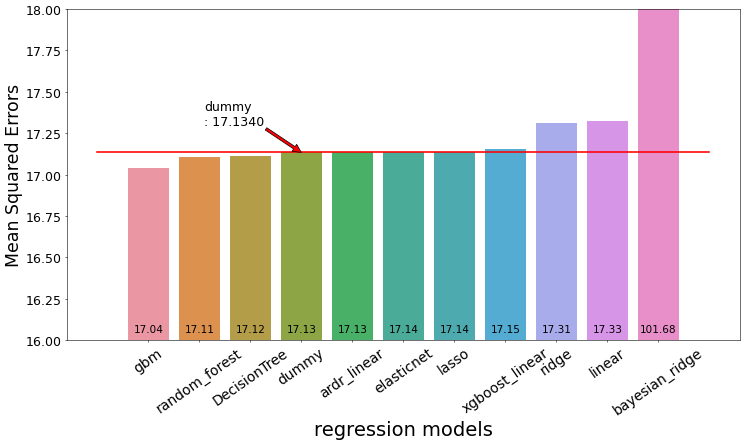

In [376]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=mse_df, capsize=.2)
_ = g.set_xticks(range(len(mse_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("regression models", fontsize = 28)
_ = g.set_ylabel("Mean Squared Errors", fontsize = 25)
_ = g.set_ylim([16, 18]) # g.set_ylim([0, 18]) # ax.set(ylim=(0.4, 0.6))

mse_dummy_mean = mse_df[mse_df.key=='dummy']['value'].values
_ = g.plot([-1,len(mse_df)], [mse_dummy_mean, mse_dummy_mean], color = 'red', linewidth = 2.3)
_ = g.annotate(text = f'dummy\n: {mse_dummy_mean[0]:.4f}', xy = (3, mse_dummy_mean), xytext = (1.1, 17.3),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = mse_df['value']
cnt = 0
for i in range(len(mse_df)):
    tmp_fval = f'{val[i]:.2f}'
    if tmp_fval.index('.') == 3:
        _ = g.text(cnt-0.355, 16.05, tmp_fval, fontsize=15)
    elif tmp_fval.index('.') == 2:
        _ = g.text(cnt-0.285, 16.05, tmp_fval, fontsize=15)
    cnt += 1

plt.tight_layout()
plt.savefig('mse_reg_plot.png')

# r2 plot

<Figure size 750x450 with 0 Axes>

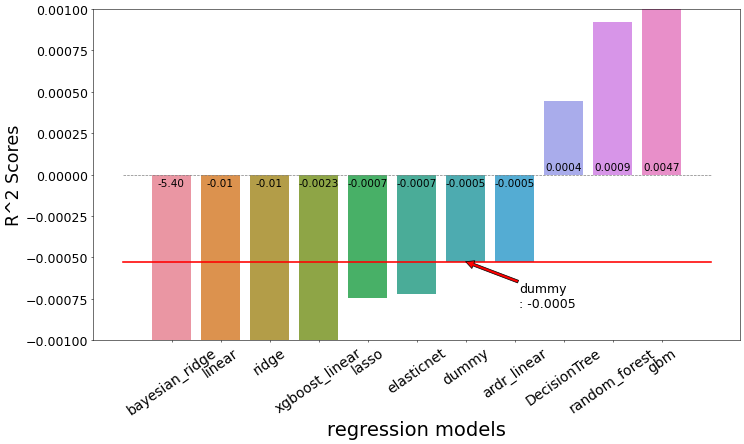

In [377]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=r2_df, capsize=.2)
_ = g.set_xticks(range(len(r2_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("regression models", fontsize = 28)
_ = g.set_ylabel("R^2 Scores", fontsize = 25)
_ = g.set_ylim([-0.001, 0.001]) # ax.set(ylim=(0.4, 0.6))
r2_dummy_mean = r2_df[r2_df.key=='dummy']['value'].values
_ = g.plot([-1,len(r2_df)], [r2_dummy_mean, r2_dummy_mean], color = 'red', linewidth = 2.3)
_ = g.plot([-1,len(cv_df)], [0, 0], color = 'gray', linestyle = '--', linewidth = 1)
_ = g.annotate(text = f'dummy\n: {r2_dummy_mean[0]:.4f}', xy = (6, r2_dummy_mean), xytext = (7.1, -0.0008),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = r2_df['value']
cnt = 0
for i in range(len(r2_df)):
    if f'{val[i]:.2f}'[-1] != '0' or f'{val[i]:.2f}'[-2] != '0':
        _ = g.text(cnt-0.28, -0.00007, f'{val[i]:.2f}', fontsize = 15)
    
    elif f'{val[i]:.2f}'[-1] == '0' and val[i] < 0:
#         tmp_val = f'{val[i]:.4f}'[-4:]
#         _ = g.text(cnt-0.47, -0.0001, f'-{tmp_val}'[:3]+'\n'+f'-{tmp_val}'[3:], fontsize = 15)
#         _ = g.text(cnt-0.47, -0.000125, f'{val[i]:.4f}'[:5]+'\n'+'    '+f'{val[i]:.4f}'[5:], fontsize = 15)
        _ = g.text(cnt-0.40, -0.00007, f'{val[i]:.4f}', fontsize = 15)


    elif val[i] > 0:
#         _ = g.text(cnt-0.4, 0.0, f'{val[i]:.4f}'[:4]+'\n'+'   '+f'{val[i]:.4f}'[4:], fontsize = 15)
        _ = g.text(cnt-0.37, 0.00003, f'{val[i]:.4f}', fontsize = 15)
    cnt += 1

plt.tight_layout()
plt.savefig('r2_reg_plot.png')

# [r2 info](https://vitalflux.com/r-squared-explained-machine-learning/)

# cv plot

<Figure size 750x450 with 0 Axes>

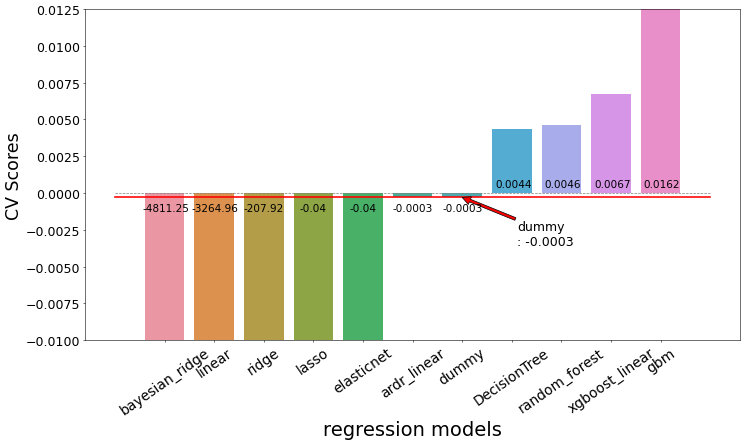

In [378]:
plt.figure(figsize=(15,9), dpi = 50)
g = sns.barplot(x = 'key', y = 'value', data=cv_df, capsize=.2)
_ = g.set_xticks(range(len(cv_df)))
_ = g.set_xticklabels(g.get_xticklabels(), rotation=35, fontsize = 20)
# _ = g.set_yticklabels(g.get_yticklabels(), fontsize = 18)
_ = plt.setp(g.get_yticklabels(), fontsize =18)
_ = g.set_xlabel("regression models", fontsize = 28)
_ = g.set_ylabel("CV Scores", fontsize = 25)
_ = g.set_ylim([-0.010, 0.0125]) # ax.set(ylim=(0.4, 0.6))
cv_dummy_mean = cv_df[cv_df.key=='dummy']['value'].values
_ = g.plot([-1,len(cv_df)], [cv_dummy_mean, cv_dummy_mean], color = 'red', linewidth = 2.3)
_ = g.plot([-1,len(cv_df)], [0, 0], color = 'gray', linestyle = '--', linewidth = 1)
_ = g.annotate(text = f'dummy\n: {cv_dummy_mean[0]:.4f}', xy = (6, cv_dummy_mean), xytext = (7.1, -0.0035),
               arrowprops = dict(facecolor = 'red', shrink = 0), fontsize = 18)


val = cv_df['value']
cnt = 0
for i in range(len(cv_df)):
    if (f'{val[i]:.2f}'[-1] != '0' or f'{val[i]:.2f}'[-2] != '0') and len(f'{val[i]:.2f}')>5:
        tmp_fval = f'{val[i]:.2f}'
        if len(tmp_fval[:tmp_fval.index('.')]) > 4:
#             _ = g.text(cnt-0.3, -0.002, tmp_fval[:tmp_fval.index('.')]+'\n'+'    '+tmp_fval[tmp_fval.index('.'):], fontsize = 15)
            _ = g.text(cnt-0.45, -0.0012, tmp_fval, fontsize = 15)
        else:
#             _ = g.text(cnt-0.3, -0.002, ' '+tmp_fval[:tmp_fval.index('.')]+'\n'+'   '+tmp_fval[tmp_fval.index('.'):], fontsize = 15)
            _ = g.text(cnt-0.4, -0.0012, tmp_fval, fontsize = 15)
            
    elif (f'{val[i]:.2f}'[-1] != '0' or f'{val[i]:.2f}'[-2] != '0') and len(f'{val[i]:.2f}')<=5 and val[i] < 0:
        _ = g.text(cnt-0.28, -0.0012, f'{val[i]:.2f}', fontsize = 15)
    
    elif f'{val[i]:.2f}'[-1] == '0' and val[i] < 0:
#         _ = g.text(cnt-0.25, -0.0019, f'{val[i]:.4f}'[:5]+'\n'+'    '+f'{val[i]:.4f}'[5:], fontsize = 15)
        _ = g.text(cnt-0.4, -0.0012, f'{val[i]:.4f}', fontsize = 15)
        
    elif val[i] > 0:
#         _ = g.text(cnt-0.22, 0.0004, f'{val[i]:.4f}'[:4]+'\n'+'   '+f'{val[i]:.4f}'[4:], fontsize = 15)
        _ = g.text(cnt-0.34, 0.0004, f'{val[i]:.4f}', fontsize = 15)
    cnt += 1

plt.tight_layout()
plt.savefig('cv_reg_plot.png')

[틱 글꼴 크기](https://www.delftstack.com/ko/howto/matplotlib/how-to-set-tick-labels-font-size-in-matplotlib/)